In [ ]:
#import all of the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics
warnings.filterwarnings("ignore")

In [ ]:
# load the dataset
fed = pd.read_csv('/content/FRB_H15.csv')
fed.head()

,Time Period,RIFSPFF_N.D
0,2025-03-14,4.33
1,2025-03-13,4.33
2,2025-03-12,4.33
3,2025-03-11,4.33
4,2025-03-10,4.33


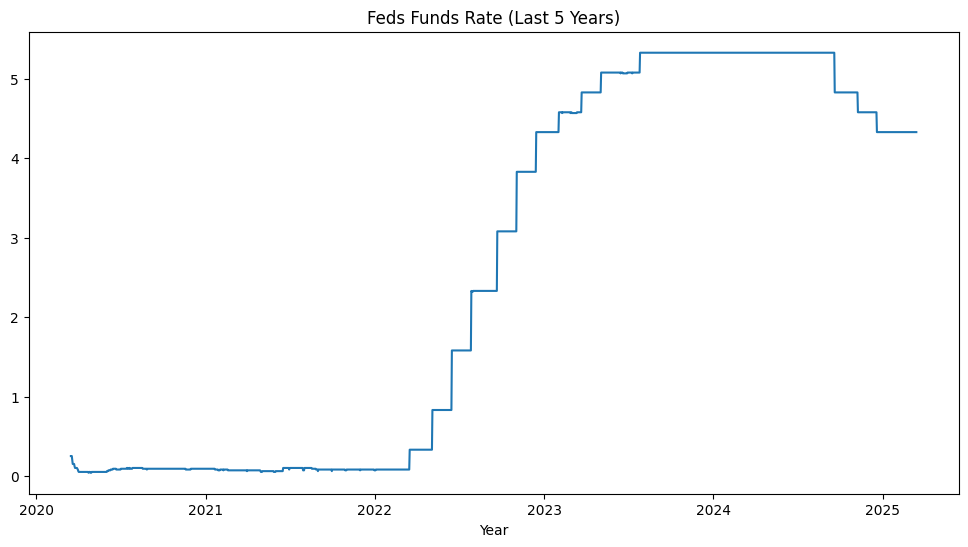

In [ ]:
# Select the last 5 years of data
fed_last_5_years = fed.head(1825)

# Convert 'Time Period' to datetime objects
fed_last_5_years['Time Period'] = pd.to_datetime(fed_last_5_years['Time Period'])

# Set the figure size (width, height) in inches
plt.figure(figsize=(12, 6))

# Plot the selected data
plt.plot(fed_last_5_years['Time Period'], fed_last_5_years['RIFSPFF_N.D'])
plt.title('Feds Funds Rate (Last 5 Years)')
plt.xlabel('Year')
plt.show()

In [ ]:
# Select the relevant column as the time series data
fed_series = fed_last_5_years['RIFSPFF_N.D']

# Perform the Augmented Dickey-Fuller test on the selected column
result = adfuller(fed_series)

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.126720
p-value: 0.946711
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
# Calculate quantiles
Q1 = fed_last_5_years['RIFSPFF_N.D'].quantile(0.25)
Q3 = fed_last_5_years['RIFSPFF_N.D'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Filter data
fed_last_5_years = fed_last_5_years[(fed_last_5_years['RIFSPFF_N.D'] >= lower_bound) &
 (fed_last_5_years['RIFSPFF_N.D'] <= upper_bound)]

In [ ]:
# Training Forecast Model with FFR Data using ARMA(1,0)
model_1 = ARIMA(fed_last_5_years['RIFSPFF_N.D'], order=(1,0,0)) # Use ARIMA and specify the data series
ffr_pred = model_1.fit()
print(ffr_pred.summary())

                               SARIMAX Results                                
Dep. Variable:            RIFSPFF_N.D   No. Observations:                 1825
Model:                 ARIMA(1, 0, 0)   Log Likelihood                3126.522
Date:                Thu, 20 Mar 2025   AIC                          -6247.045
Time:                        06:23:14   BIC                          -6230.517
Sample:                             0   HQIC                         -6240.948
                               - 1825                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5772     22.608      0.114      0.909     -41.733      46.888
ar.L1          0.9999      0.000   3078.680      0.000       0.999       1.001
sigma2         0.0019    8.4e-06    225.370      0.0

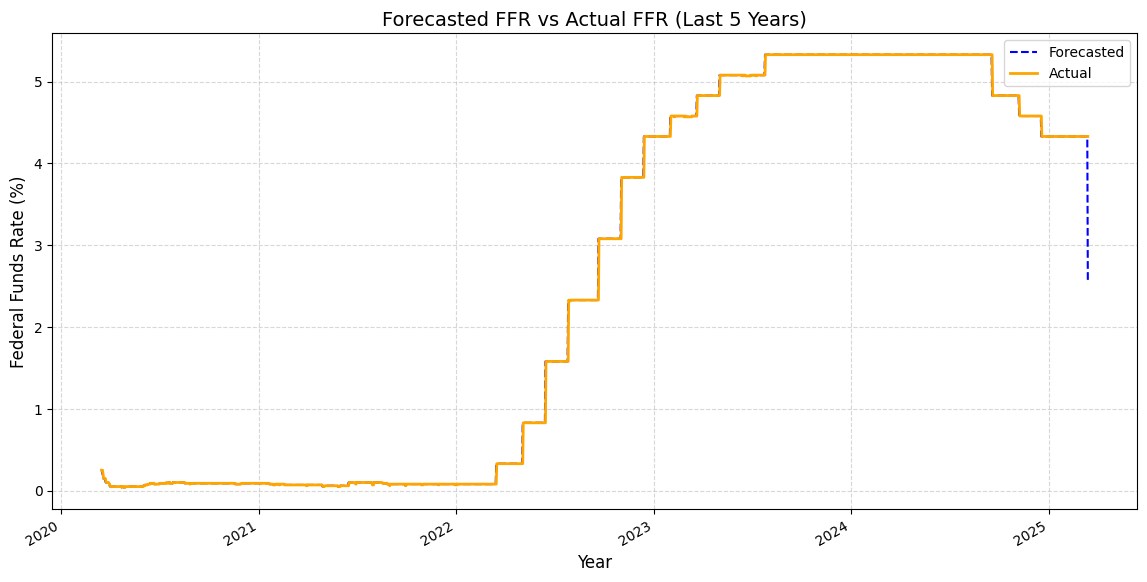

In [ ]:
# Get the index corresponding to five_years_ago
start_index = fed_last_5_years.index.min()

# Get the index corresponding to the last date
end_index = fed_last_5_years.index.max()

# Predict using date-based indexing
start_date = fed_last_5_years['Time Period'].min()
end_date = fed_last_5_years['Time Period'].max()

# Get predictions for the last 5 years using index values
predictions = ffr_pred.predict(start=start_index, end=end_index)

# Reset predictions index to match fed_last_5_years
predictions.index = fed_last_5_years.index

plt.figure(figsize=(14, 7))  # Larger figure for better readability

# Plot the data
plt.plot(fed_last_5_years['Time Period'], predictions, label='Forecasted', color='blue', linestyle='--')
plt.plot(fed_last_5_years['Time Period'], fed_last_5_years['RIFSPFF_N.D'], label='Actual', color='orange', linewidth=2)

# Add labels and legend
plt.legend(fontsize=10)
plt.title('Forecasted FFR vs Actual FFR (Last 5 Years)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Federal Funds Rate (%)', fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve x-axis label formatting
plt.gcf().autofmt_xdate()

# display
plt.show()

In [ ]:
model_1 = SARIMAX(fed_last_5_years['RIFSPFF_N.D'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))

# Use the length of fed_last_5_years for prediction
acc_1_pred = ffr_pred.predict(start=0, end=len(fed_last_5_years) -1 )

# Select only the 'RIFSPFF_N.D' column for comparison, ensuring numerical data
acc_1_true = fed_last_5_years['RIFSPFF_N.D']
print('Mean Squared Error = ' , metrics.mean_squared_error(acc_1_true , acc_1_pred))
print('Mean Absolute Error = ' , metrics.mean_absolute_error(acc_1_true , acc_1_pred))

Mean Squared Error =  0.0035771126513491377
Mean Absolute Error =  0.005035752529423839


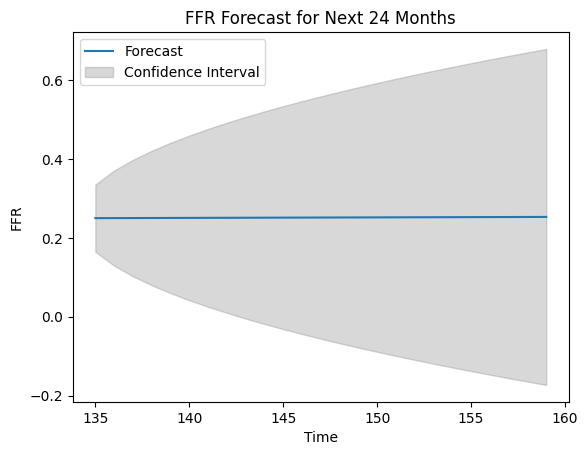

In [ ]:
# Instead, use get_forecast on the fitted model:
forecast_results = ffr_pred.get_forecast(steps=25, alpha=0.05)  # steps=25 for 24 months + 1

# Extract forecast, stderr, and conf_int from forecast_results
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()
stderr = forecast_results.se_mean  # If you need standard error

# Convert the index to integers (assuming your original index is a RangeIndex)
forecast_index = np.arange(135, 160)

# Plot the forecast and confidence intervals
plt.plot(forecast_index, forecast, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')

plt.legend()
plt.title('FFR Forecast for Next 24 Months')
plt.xlabel('Time')
plt.ylabel('FFR')
plt.show()